In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [5]:
data = tf.keras.utils.image_dataset_from_directory('data')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
class_names = ['excellent', 'poor', 'good']
features, targets = batch

Found 7330 files belonging to 3 classes.


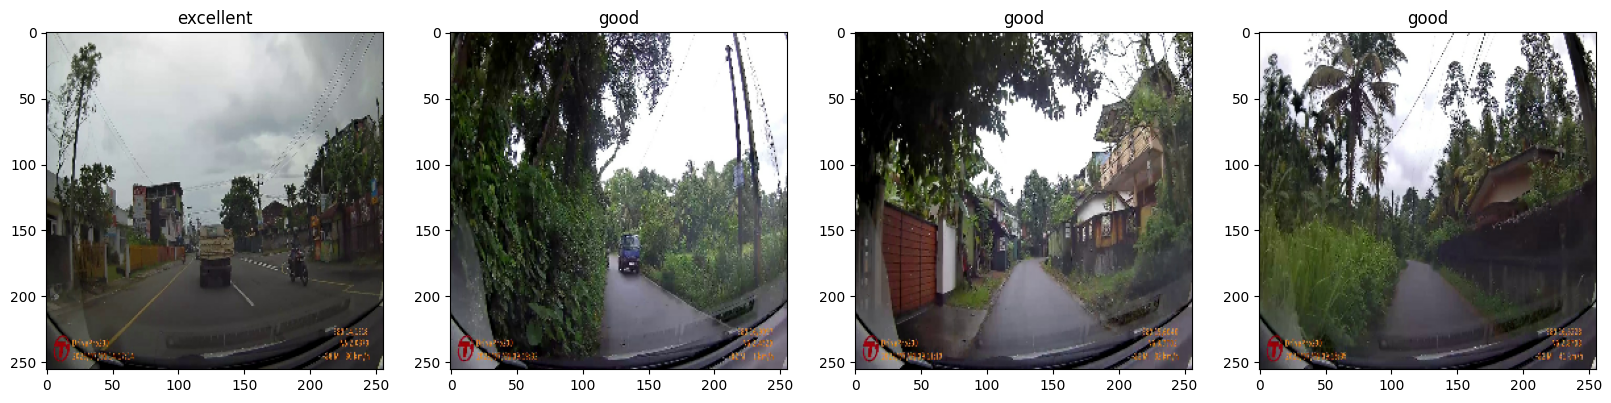

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_names[batch[1][idx]])

In [7]:
data = data.map(lambda x,y: (x/255, y))
batch = data.as_numpy_iterator().next()

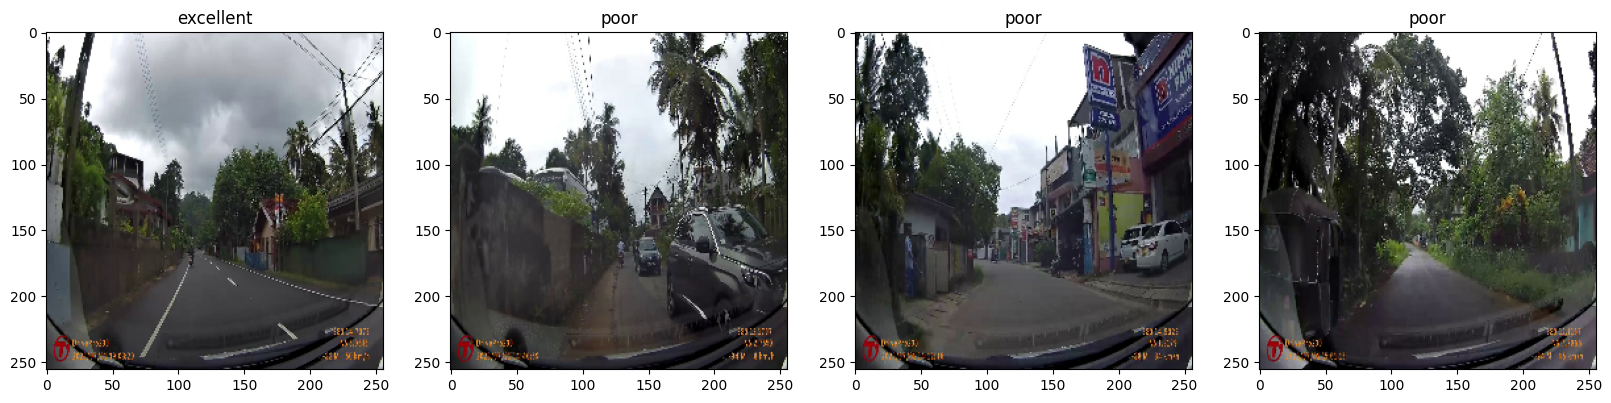

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[batch[1][idx]])

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10


161/161 [==============================] - 91s 555ms/step - loss: 8.6481 - accuracy: 0.5596 - val_loss: 8.7970 - val_accuracy: 0.4918
Epoch 2/10
161/161 [==============================] - 91s 560ms/step - loss: 2.6009 - accuracy: 0.7562 - val_loss: 1.3430 - val_accuracy: 0.8071
Epoch 3/10
161/161 [==============================] - 92s 565ms/step - loss: 2.2410 - accuracy: 0.7884 - val_loss: 0.9377 - val_accuracy: 0.8682
Epoch 4/10
161/161 [==============================] - 100s 611ms/step - loss: 3.9326 - accuracy: 0.7424 - val_loss: 4.6711 - val_accuracy: 0.7188
Epoch 5/10
161/161 [==============================] - 91s 556ms/step - loss: 1.5865 - accuracy: 0.8465 - val_loss: 1.4102 - val_accuracy: 0.8444
Epoch 6/10
161/161 [==============================] - 78s 482ms/step - loss: 1.2052 - accuracy: 0.8645 - val_loss: 2.0856 - val_accuracy: 0.7683
Epoch 7/10
161/161 [==============================] - 78s 482ms/step - loss: 2.2220 - accuracy: 0.8255 - val_loss: 1.4405 - val_accuracy: 0.

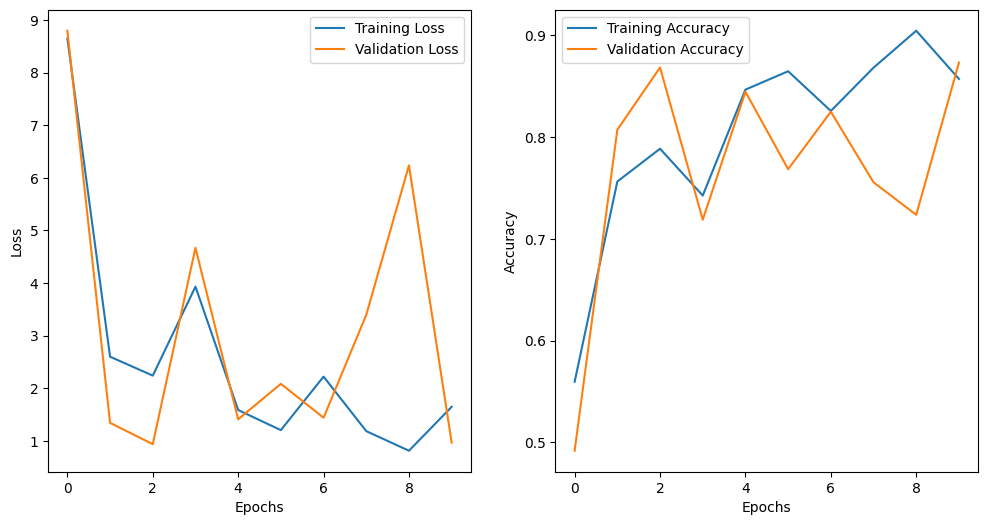

Final Training Loss: 1.6477
Final Training Accuracy: 0.8569
Final Validation Loss: 0.9679
Final Validation Accuracy: 0.8730


In [14]:
# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Print final training and validation loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Training Accuracy: {final_train_accuracy:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

In [41]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('road_quality_model.h5')

In [61]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('road_quality_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               25165952  
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 25,167,242
Trainable params: 25,167,242
Non-trainable params: 0
_________________________________________________________________


In [54]:
loss, acc = new_model.evaluate(test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

23/23 - 27s - loss: 3.4294 - accuracy: 0.8229 - 27s/epoch - 1s/step
Restored model, accuracy: 82.29%


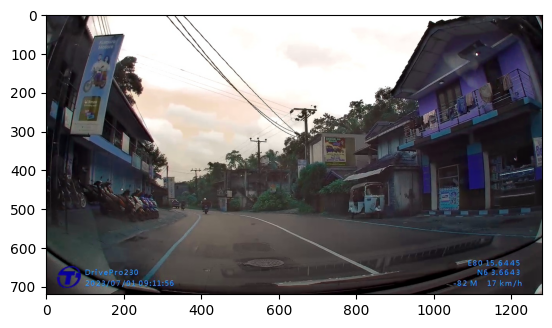

In [74]:
img = cv2.imread('frame_25.jpg')
plt.imshow(img)
plt.show()

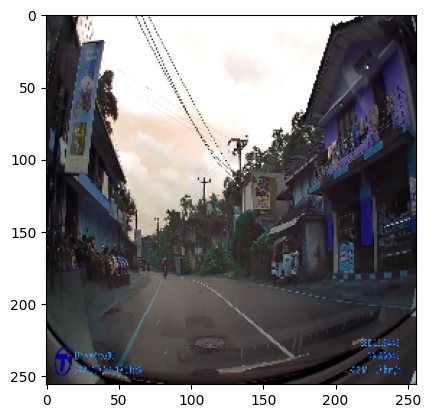

In [75]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

1/1 [==============================] - 0s 37ms/step


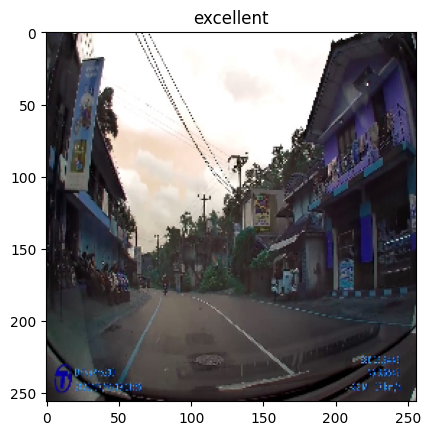

In [76]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))
predicted_class = np.argmax(yhat)

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.title(class_names[predicted_class])
plt.show()
